## **Imports**

In [ ]:
!pip install mtcnn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.3 MB 30.4 MB/s 


In [ ]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Conv2D, ZeroPadding2D, MaxPooling2D, Flatten, Dense, Dropout, Activation
from PIL import Image
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, save_img, img_to_array
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import mtcnn
import os

## **Define VGGFace sequential model**

In [ ]:
def get_model():
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(Conv2D(4096, (7, 7), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Conv2D(4096, (1, 1), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Conv2D(2622, (1, 1)))
    model.add(Flatten())
    model.add(Activation('softmax'))
    return model
  


## **Connect Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Instantiation and Weights Loading**

In [ ]:
model = get_model()
model.load_weights(filepath="./drive/MyDrive/faces_seminar/vgg_face_weights.h5")

vgg_face_descriptor = Model(inputs = model.layers[0].input, outputs=model.layers[-2].output)

## **Face Verification**

In [ ]:
def face_verification(img1, img2, show=True):  
  img1_preprocessed = preprocess_image(img1)
  img2_preprocessed = preprocess_image(img2)

  img1_representation = vgg_face_descriptor.predict(img1_preprocessed)
  img2_representation = vgg_face_descriptor.predict(img2_preprocessed)

  if show:
    fig = plt.figure()
    fig.add_subplot(1,2,1)

    plt.imshow(plt.imread(img1))

    plt.xticks([])
    plt.yticks([])

    fig.add_subplot(1,2,2)
    plt.imshow(plt.imread(img2))

    plt.xticks([])
    plt.yticks([])

    plt.show(block=True)
  distance = cosine_similarity(img1_representation, img2_representation)[0][0]
  #print("Cosine similarity: ", distance)

  return distance


In [ ]:
def cosine_similarity(rep1, rep2):
  nominator = rep1 @ rep2.T
  denominator = np.linalg.norm(rep1) * np.linalg.norm(rep2)
  return nominator / denominator

## **Sanity checks**

In [ ]:
root = "./drive/MyDrive/faces_seminar/aligned_examples/"

filenames = os.listdir(root)
for i, filename1 in enumerate(filenames):
  for j, filename2 in enumerate(filenames):
    img1_path = root + filename1
    img2_path = root + filename2
    print(face_verification(img1_path, img2_path))


NameError: ignored

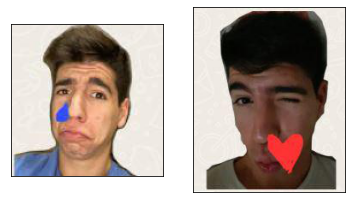

0.7297909

In [ ]:
img1_path = "./drive/MyDrive/faces_seminar/aligned_examples/dror4.jpg"
img2_path = "./drive/MyDrive/faces_seminar/aligned_examples/dror5.jpg"

face_verification(img1_path, img2_path)

## **Utility functions**

In [ ]:
def preprocess_image(image_path):
  img = load_img(path=image_path, target_size=(224, 224))
  img = img_to_array(img)
  img = np.expand_dims(img, axis=0)
  img = preprocess_input(img)
  return img

In [ ]:
def cropped_image(img):
  detector = mtcnn.MTCNN()     
  face = detector.detect_faces(img)[0]  
  x,y,w,h = face["box"]  
  cropped_image = img[y:y+h,x:x+w]  
  return cropped_image

In [ ]:
#returns list of representations (of type np.array())
def get_representations(root):
  folders = sorted(os.listdir(root))
  lst = []
  for folder in folders:
    for i in range(1,3):
      img = preprocess_image(root + "/" + folder + f"/im{i}.jpg" )
      representation = vgg_face_descriptor.predict(img)[0]
      lst.append(representation)
  return lst

In [ ]:
#returns list of representations (of type np.array())
def get_video_1_folder_representations(root):
  vid1_reps = []
  vid2_reps = []

  n = len(os.listdir(root + "vid1/"))
  m = len(os.listdir(root + "vid2/"))    

  for i in range(1,n+1):
    img = preprocess_image(root + "vid1/" + f"vid1_{i}.jpg" )
    representation = vgg_face_descriptor.predict(img)[0]
    vid1_reps.append(representation)
  
  for j in range(1,m+1):
    img = preprocess_image(root + "vid2/" + f"vid2_{j}.jpg" )
    representation = vgg_face_descriptor.predict(img)[0]
    vid2_reps.append(representation)

  return vid1_reps, vid2_reps

In [ ]:
def aligned_images(root, folders):  
  lst = []

  for folder in folders:
    print(folder)
    for i in range(1,3):      
      img_path = root + "/" + folder + f"/im{i}.jpg"
      img = plt.imread(img_path)[:,:,0:3]      
      img = cropped_image(img)               
      #plt.imsave(root + "/" + folder + f"/im{i}.jpg", img)
      lst.append(img)      

  return lst

In [ ]:
def get_images(root):
  folders = sorted(os.listdir(root))
  lst = []

  for folder in folders:
    for i in range(1,3):      
      img_path = root + "/" + folder + f"/im{i}.jpg"
      img = plt.imread(img_path)[:,:,0:3]                
      lst.append(img)      

  return lst

In [ ]:
def get_images_paths(root):
  folders = sorted(os.listdir(root))
  lst = []

  for folder in folders:
    for i in range(1,3):      
      img_path = root + "/" + folder + f"/im{i}.jpg"  
      lst.append(img_path)      

  return lst

In [ ]:
##################################################################### DEPRECATED #####################################################################
'''def images_rdm(images_lst, root):    
  n = int(len(images_lst) / 2)
  rdm = np.zeros((2*n, 2*n))
  
  images_lst = get_images_paths(root)
  
  for i in range(2*n):  
    print(i, end=" ")  
    for j in range(2*n):      
      img1 = preprocess_image(images_lst[i])
      img2 = preprocess_image(images_lst[j])

      img1_representation = vgg_face_descriptor.predict(img1)
      img2_representation = vgg_face_descriptor.predict(img2)
      
      rdm[i,j] = cosine_similarity(img1_representation, img2_representation)
  
  return rdm   '''

In [ ]:
def images_rdm(images_lst, root):    
  n = int(len(images_lst) / 2)
  rdm = np.zeros((2*n, 2*n))
  
  representations = get_representations(root)
  
  for i in range(2*n):  
    for j in range(2*n):                  
      rdm[i,j] = cosine_similarity(representations[i], representations[j])
  
  return rdm

In [ ]:
######################################################## ALREADY ALIGNED, NO NEED TO RE RUN ############################################################
def align_videos():
  root = "./drive/MyDrive/faces_seminar/visual_data/videos_as_images/"
  target_root = "./drive/MyDrive/faces_seminar/visual_data/aligned_videos_as_images/"
  folders = os.listdir(root)
  for folder in folders:
    filenames = os.listdir(root + folder)
    print(folder)
    for filename in filenames:
      img = plt.imread(root + folder + "/" + filename)      
      cropped = cropped_image(img)
      plt.imsave(target_root + folder + "/" + filename, cropped)
      
#align_videos()

## **Write Representation to drive (./faces_seminar/text_data)**




In [ ]:
################################################################ already written, no need to rerun ##########################################################
def write_representations(root):
  folders = sorted(os.listdir(root))
  file = open("./drive/MyDrive/faces_seminar/text_data/aligned_images_representations.txt", "w")
  for folder in folders:
    for i in range(1,3):
      img = preprocess_image(root + "/" + folder + f"/im{i}.jpg" )
      representation = vgg_face_descriptor.predict(img)[0]
      file.write(folder + f"/im{i}.jpg\n")
      file.write(str(representation) + "\n")
  file.close()

root = "./drive/MyDrive/faces_seminar/visual_data/aligned_images"
#write_representations(root)

## **Representations dissimilarity matrix**

In [ ]:
root = "./drive/MyDrive/faces_seminar/visual_data/aligned_images"
lst = get_images(root)
rdm = images_rdm(lst, root)


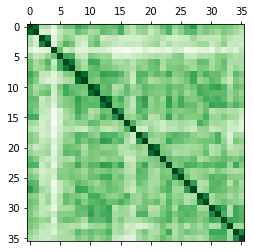

In [ ]:
fig, ax = plt.subplots()
ax.matshow(rdm, cmap=plt.cm.Greens)
plt.show()

**Rdm - Zoomed In - 8x8**

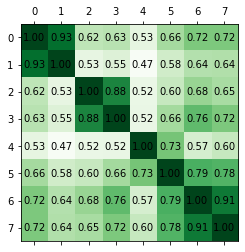

In [ ]:
zoomedin_rdm = rdm[:8,:8]

fig, ax = plt.subplots()
ax.matshow(zoomedin_rdm, cmap=plt.cm.Greens)

for (i, j), z in np.ndenumerate(zoomedin_rdm):
    ax.text(j, i, '{:0.2f}'.format(z), ha='center', va='center')
plt.show()

# **Hyperparameter Finetuning: Threshold**
### **Threshold = 0.74**
### **Diff: 84.31%**
### **Same:88.89%**

In [ ]:
def get_best_threshold_diff(rdm, thresholds):
  n = int(len(rdm[0]) / 2)
  best_threshold = 0
  best_accuracy = 0
  accuracies = np.zeros(len(thresholds))
  for t, threshold in enumerate(thresholds):
    for i in range(2*n):
      for j in range(2*n):
        if i == j or (i%2==0 and i+1 == j) or (i%2==1 and i-1==j): # same person
          continue
        else: # not the same person
            if rdm[i,j] < threshold:
              accuracies[t]+=1
    
  accuracies /= (2*2*n*n - 4*n)
  return accuracies

In [ ]:
def get_best_threshold_same(rdm, thresholds):
  n = int(len(rdm[0]) / 2)
  best_threshold = 0
  best_accuracy = 0
  accuracies = np.zeros(len(thresholds))
  for t, threshold in enumerate(thresholds):
    for i in range(2*n):
      for j in range(2*n):
        if i == j or (i%2==0 and i+1 == j) or (i%2==1 and i-1==j): # same person
          if rdm[i,j] > threshold:
            accuracies[t]+=1 
        else: # not the same person
            continue
    
  accuracies /= (4*n)
  return accuracies



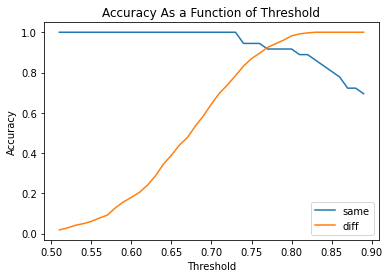

0.869281045751634
0.9444444444444444
Threshold=0.51.
Same=100.0%.
Diff=1.7973856209150325%.

Threshold=0.52.
Same=100.0%.
Diff=2.7777777777777777%.

Threshold=0.53.
Same=100.0%.
Diff=4.084967320261438%.

Threshold=0.54.
Same=100.0%.
Diff=4.901960784313726%.

Threshold=0.55.
Same=100.0%.
Diff=6.045751633986928%.

Threshold=0.56.
Same=100.0%.
Diff=7.6797385620915035%.

Threshold=0.5700000000000001.
Same=100.0%.
Diff=9.15032679738562%.

Threshold=0.58.
Same=100.0%.
Diff=12.745098039215685%.

Threshold=0.59.
Same=100.0%.
Diff=15.686274509803921%.

Threshold=0.6.
Same=100.0%.
Diff=17.973856209150327%.

Threshold=0.61.
Same=100.0%.
Diff=20.424836601307188%.

Threshold=0.62.
Same=100.0%.
Diff=24.019607843137255%.

Threshold=0.63.
Same=100.0%.
Diff=28.594771241830063%.

Threshold=0.64.
Same=100.0%.
Diff=34.47712418300654%.

Threshold=0.65.
Same=100.0%.
Diff=38.88888888888889%.

Threshold=0.66.
Same=100.0%.
Diff=43.95424836601307%.

Threshold=0.67.
Same=100.0%.
Diff=47.712418300653596%.

Thresh

In [ ]:
thresholds = [0.5 + 0.01*i for i in range(1,40)]
diff_accuracies = get_best_threshold_diff(rdm, thresholds)
same_accuracies = get_best_threshold_same(rdm, thresholds)

plt.plot(thresholds, same_accuracies, label="same")
plt.plot(thresholds, diff_accuracies, label="diff")
plt.xlabel("Threshold")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy As a Function of Threshold")
plt.show()

print(diff_accuracies[24])
print(same_accuracies[24])
for i in range(1,40):
  print(f"Threshold={thresholds[i-1]}.")
  print(f"Same={same_accuracies[i-1]*100}%.")
  print(f"Diff={diff_accuracies[i-1]*100}%.")
  print()

## **Compare Videos vs Images**

Compare im1.jpgs of identities 0, 6 (cosine distance between images = 0.72>threshold=0.71)

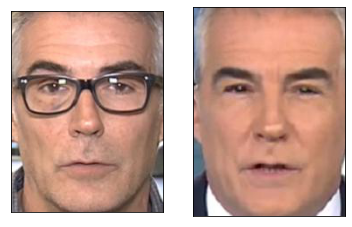

0.7318995
0.7318995
True


In [ ]:
representations = get_representations("./drive/MyDrive/faces_seminar/visual_data/aligned_images/")
path1 = "./drive/MyDrive/faces_seminar/visual_data/aligned_images/David Cantero (ES)/im1.jpg"
path2 = "./drive/MyDrive/faces_seminar/visual_data/aligned_images/David Cantero (ES)/im2.jpg"

dist1 = cosine_similarity(representations[4], representations[5])
dist2 = face_verification(path1, path2)

#Sanity check
print(dist1)
print(dist2)
print(abs(dist1-dist2) < 1e6**-1 )

## **Compare similarities via videos**

In [ ]:
video_representations = []
root = "./drive/MyDrive/faces_seminar/visual_data/aligned_videos_as_images/"
folders = sorted(os.listdir(root))
n = len(folders)

for i, folder in enumerate(folders):
  print(i, folder)
  reps1, reps2 = get_video_1_folder_representations(f"./drive/MyDrive/faces_seminar/visual_data/aligned_videos_as_images/{folder}/")
  video_representations.append(reps1)
  video_representations.append(reps2)

0 Babis Papadimitriou (GR)
1 Christos Giannoulis (GR)
2 David Cantero (ES)
3 Dermot Murnaghan (UK)
4 Evangelos Antonaros (GR)
5 George Autias (GR)
6 Giorgos Vathiotis (GR)
7 Grigoris Psarianos (GR)
8 Mario Picazo (ES)
9 Michalis Tremopoulos (GR)
10 Nikos Hadjinikolaou (GR)
11 Nikos Vatopoulos (GR)
12 Pedro Piqueras (ES)
13 Stamatis Malelis (GR)
14 Stelios Kouloglou (GR)
15 Tasos Telloglou (GR)
16 Terrence Quick (GR)
17 Theodoros Roussopoulos (GR)


## **Compare images distances to videos distances. Also, extract video distances std, in addition to mean**

In [ ]:
def get_mean_std_similarity_of_2_video_representations(reps1, reps2):
  similarities = np.zeros(min(len(reps1), len(reps2)))
  for i in range(len(similarities)):
    similarities[i] = cosine_similarity(reps1[i], reps2[i])
    
  return np.mean(similarities), np.std(similarities)


M=0.8562297059430016, STD=0.061645010403268925
M=0.7481350303525319, STD=0.11374219352206826


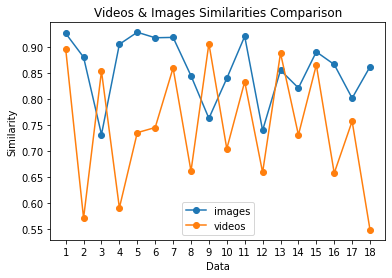

In [ ]:
images_distances = np.zeros(18)
videos_distances = np.zeros(18)
videos_stds = np.zeros(18)
for i in range(18):
  images_distances[i] = rdm[2*i, 2*i + 1]

for i in range(18):
  videos_distances[i], videos_stds[i] = get_mean_std_similarity_of_2_video_representations(video_representations[i], video_representations[i+1])

plt.plot([i for i in range(1,19)], images_distances, label="images", marker = 'o')
print(f"M={np.mean(images_distances)}, STD={np.std(images_distances)}")
plt.plot([i for i in range(1,19)], videos_distances, label="videos", marker = 'o')
print(f"M={np.mean(videos_distances)}, STD={np.std(videos_distances)}")

plt.legend()
plt.xlabel("Data")
plt.ylabel("Similarity")
plt.xticks([i for i in range(1,19)])
plt.title("Videos & Images Similarities Comparison")
plt.show()


# **Variance of same representations**

In [1]:
variances = np.zeros(18)
similarities = np.zeros(18)

for i in range(18):
  reps1 = video_representations[2*i]
  reps2 = video_representations[2*i + 1]
  similarities = []
  for j in range(min(len(reps1), len(reps2))):
    similarities.append(cosine_similarity(reps1[j], reps2[j]))
  if (i==5):
    print(f"news reporter 6: M={np.mean(similarities)}, STD={np.std(similarities)}")
    plt.plot(similarities)
    plt.xlabel("Frame")
    plt.ylabel("Similarity score")
    plt.title("Similarity score as a Function of Frames")
    plt.show()  
  variances[i] = np.var(similarities)

print(f"M={np.mean(variances)}, STD={np.std(variances)}")
plt.plot([i for i in range(1,19)], variances, marker="o")
plt.xlabel("Video Data")
plt.xticks([i for i in range(1,19)])
plt.ylabel("Variance")
plt.title("Variances of Videos Representations Similarities")
plt.show()

NameError: ignored

## **Same videos**

In [ ]:
thresholds = [0.5 + 0.01*i for i in range(50)]
same_accuracies = [0 for i in range(50)]

same_means = np.zeros(n)
for t, threshold in enumerate(thresholds):
  correct = 0
  for i,folder in enumerate(folders):
    reps_amount = min(len(video_representations[2*i]), len(video_representations[2*i+1]))
    similarities = []

    reps1 = video_representations[2*i]   #85 representations for each frame
    reps2 = video_representations[2*i+1] #85 representations for each frame

    for j in range(reps_amount):    
      similarities.append(cosine_similarity(reps1[j], reps2[j]))
    
    if np.mean(similarities) > threshold:
      correct += 1
    print("mean: ", np.mean(similarities))
    same_means[i] = np.mean(similarities)
    
    plt.plot([i for i in range(reps_amount)], similarities)
    plt.plot([i for i in range(reps_amount)], [0.74 for i in range(reps_amount)], label="Threshold")

    plt.xlabel("Frame")
    plt.ylabel("Similarity")
    plt.legend()
    plt.title(f"{folder}: Similarity between frames")
    plt.show()
    print("-----------------------------------------------\n")
  '''print("Thresholds:", threshold)
  print(f"Total correct:{correct/n*100}%.")
  print()'''
  same_accuracies[t] = correct/n*100
#print(f"Means similarity:{np.mean(same_means)}%.")

## **Different Videos**

In [ ]:
#Get vid1 of each class
video1_representations = [video_representations[2*i] for i in range(n)] 
thresholds = [0.5 + 0.01*i for i in range(50)]
diff_accuracies = [0 for i in range(50)]
for t,threshold in enumerate(thresholds):
  correct = 0
  for i in range(n):
    for j in range(i+1,n):
      if i==j: continue
      reps_amount = min(len(video_representations[i]), len(video_representations[j]))
      similarities = []

      reps1 = video_representations[i]   #85 representations for each frame
      reps2 = video_representations[j] #85 representations for each frame

      for k in range(reps_amount):    
        similarities.append(cosine_similarity(reps1[k], reps2[k]))
      
      if np.mean(similarities) < threshold:
        correct += 1
      #print("mean: ", np.mean(similarities))
      same_means[i] = np.mean(similarities)
  
      plt.plot([i for i in range(reps_amount)], similarities)
      plt.plot([i for i in range(reps_amount)], [0.74 for i in range(reps_amount)], label="Threshold")

      plt.xlabel("Frame")
      plt.ylabel("Similarity")
      plt.legend()
      plt.title(f"{folder}: Similarity between frames")
      plt.show()
      print("-----------------------------------------------\n")
  print("Threshold:", threshold)
  print(f"Total correct:{correct/((n*n-n)/2)*100}%.") # N= n(a1+a_n) / 2
  print()
  diff_accuracies[t] = correct/((n*n-n)/2)*100

NameError: ignored

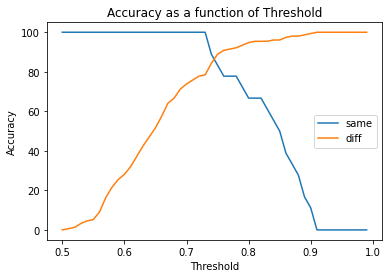

Threshold: 0.7
same: 100.0
diff: 73.8562091503268

Threshold: 0.71
same: 100.0
diff: 75.81699346405229

Threshold: 0.72
same: 100.0
diff: 77.77777777777779

Threshold: 0.73
same: 100.0
diff: 78.43137254901961

Threshold: 0.74
same: 88.88888888888889
diff: 84.31372549019608

Threshold: 0.75
same: 83.33333333333334
diff: 88.88888888888889

Threshold: 0.76
same: 77.77777777777779
diff: 90.84967320261438

Threshold: 0.77
same: 77.77777777777779
diff: 91.50326797385621

Threshold: 0.7799999999999999
same: 77.77777777777779
diff: 92.15686274509804

Threshold: 0.7899999999999999
same: 72.22222222222221
diff: 93.4640522875817



In [ ]:
plt.plot(thresholds, same_accuracies, label="same")
plt.plot(thresholds, diff_accuracies, label="diff")
plt.legend()
plt.xlabel("Threshold")
plt.ylabel("Accuracy")
plt.title("Accuracy as a function of Threshold")
plt.show()

for i in range(10):
  print("Threshold:", 0.7 + i*0.01)
  print("same:", same_accuracies[20+i])
  print("diff:", diff_accuracies[20+i])
  print()

Text(0, 0.5, 'Accuracy')

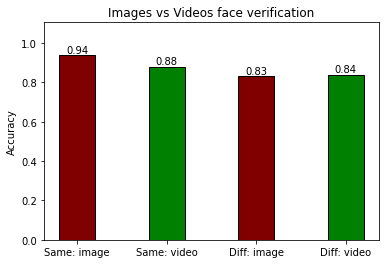

In [ ]:
# best threshold for videos - 0.74
#same
plt.bar(["Same: image"], [0.94], width=0.4, ec="black", color="maroon")
plt.bar(["Same: video"], [0.88], width=0.4, ec="black", color="green")

#diff
plt.bar(["Diff: image"], [0.83], width=0.4, ec="black", color="maroon")
plt.bar(["Diff: video"], [0.84], width=0.4, ec="black", color="green")


plt.title("Images vs Videos face verification")
plt.text(x=0, y=0.94, s="0.94", va="bottom", ha="center")
plt.text(x=1, y=0.88, s="0.88", va="bottom", ha="center")

plt.text(x=2, y=0.83, s="0.83", va="bottom", ha="center")
plt.text(x=3, y=0.84, s="0.84", va="bottom", ha="center")

plt.ylim([0,1.105])
plt.ylabel("Accuracy")

(0.0, 1.105)

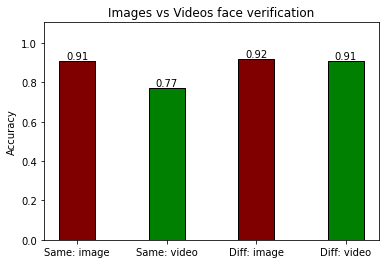

In [ ]:
# best threshold for images - 0.77
#same
plt.bar(["Same: image"], [0.91], width=0.4, ec="black", color="maroon")
plt.bar(["Same: video"], [0.77], width=0.4, ec="black", color="green")

#diff
plt.bar(["Diff: image"], [0.92], width=0.4, ec="black", color="maroon")
plt.bar(["Diff: video"], [0.91], width=0.4, ec="black", color="green")


plt.title("Images vs Videos face verification")
plt.text(x=0, y=0.91, s="0.91", va="bottom", ha="center")
plt.text(x=1, y=0.77, s="0.77", va="bottom", ha="center")

plt.text(x=2, y=0.92, s="0.92", va="bottom", ha="center")
plt.text(x=3, y=0.91, s="0.91", va="bottom", ha="center")

plt.ylabel("Accuracy")
plt.ylim([0,1.105])
